https://github.com/mrsys/NLP_Going_Deeper/blob/main/NLP_Project_7.ipynb를 참고하였다

In [ ]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)

# torch version
print(torch.__version__)

2.8.0+cu126


1. Tokenizer 준비
SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만드세요.

이를 위해 한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만들어 보세요. BERT에 사용되는 주요 특수문자가 vocab에 포함되어야 합니다. (시간이 부족하다면 클라우드에 저장된 sentencepiece 모델을 사용하세요.)



In [ ]:
corpus_file = 'kowiki.txt'

In [ ]:
prefix = 'ko_8000'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 문장 분리, classification, 마스킹 토큰

In [ ]:
vocab = spm.SentencePieceProcessor()
vocab.load("ko_8000.model")


print("=" * 100)
print(f"Vocab Size: {vocab.get_piece_size():,}")
print("SentencePiece Token:", [vocab.id_to_piece(idx) for idx in range(7, 12)]) # 특수 토큰을 제한 5개 토큰 보가
print("=" * 100)

Vocab Size: 8,007
SentencePiece Token: ['▁1', '▁이', '으로', '에서', '▁있']


2. 데이터 전처리 (1) MASK 생성
BERT의 MLM에 필요한 빈칸(mask)을 학습 데이터 전체 토큰의 15% 정도로 만들어 주세요. 그 중 80%는 [MASK] 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용하세요.

In [ ]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)
    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        dice = random.random()
        for index in index_set:
            masked_token = None
            if dice < 0.8:
                masked_token = "[MASK]"
            elif dice < 0.9:
                masked_token = tokens[index]
            else:
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

In [ ]:
#Mask 생성 예제=========================
tokens_org = vocab.encode_as_pieces("나는 어제 밥을 먹었다.")

vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))

mask_cnt = int((len(tokens_org) - 3) * 0.5)
tokens, mask_idx, mask_label = create_pretrain_mask(tokens_org.copy(), mask_cnt, vocab_list)

print("=" * 100)
print("Example Sentence:", tokens_org, end="\n\n")
print(" AFER MASKING ".center(50, "↓"), end="\n\n")
print("Masked Sentence:", tokens)
print("`mask_idx`:", mask_idx)
print("`mask_label`:", mask_label)
print("=" * 100)

Example Sentence: ['▁나', '는', '▁어', '제', '▁', '밥', '을', '▁먹', '었다', '.']

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ AFER MASKING ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

Masked Sentence: ['▁나', '는', '[MASK]', '[MASK]', '▁', '밥', '을', '▁먹', '었다', '.']
`mask_idx`: [2, 3]
`mask_label`: ['▁어', '제']


3. 데이터 전처리 (2) NSP pair 생성
BERT의 pretrain task인 NSP는 두 문장이 연속하는지 확인하는 것입니다. 이를 위해 2개의 문장을 짝지어 50%의 확률로 TRUE와 FALSE를 지정해 주세요.

두 문장 사이에 segment 처리를 해주세요. 첫 번째 문장의 segment는 0, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주세요.

MLM과 NSP는 동시에 학습된다는 것을 염두에 두고 학습 데이터를 구성해 보세요.

In [ ]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [ ]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [ ]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):

        current_chunk.append(doc[i])
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

In [ ]:
#NSP 생성 예제==================================
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
"""

doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
instances = create_pretrain_instances(vocab, doc, 64, 0.15, vocab_list)

print("=" * 100)
for key, value in instances[0].items():
    print(f"{key}: {value}", end="\n\n")
print("=" * 100)

tokens: ['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '[SEP]', '[MASK]', '[MASK]', '[MASK]', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[SEP]']

segment: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

is_next: 1

mask_idx: [13, 14, 15]

mask_label: ['▁그', '날', '은']



세그먼트, 마스킹이 이루어졌다

4. 데이터 전처리 (3) 데이터셋 완성
BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요. 데이터셋의 사이즈가 크므로np.memmap을 사용해 메모리 사용량을 최소화해 보세요.

In [ ]:
corpus_file = 'kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [ ]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다.
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []



#create data and save=============================
pretrain_json_path = 'bert_pre_train.json'
make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1

print("=" * 100)
print(f"Data Num: {total:,}")
print("=" * 100)

  0%|          | 0/3957761 [00:00<?, ?it/s]

Data Num: 918,173


918173 개의 데이터를 얻었다.

In [ ]:
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


In [ ]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break

    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.full(n_seq, dtype=np.int32, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [ ]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

data load early stop 128000 128000


5. BERT 모델 구현
pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.

Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, pretraine용 BERT 모델을 만들어 봅시다.

In [ ]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = (tokens == i_pad).float()
    mask = mask.unsqueeze(1)
    return mask

def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tokens.size(1)
    ahead_mask = 1 - torch.tril(torch.ones((n_seq, n_seq)))
    ahead_mask = ahead_mask.unsqueeze(0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = torch.maximum(ahead_mask, pad_mask)
    return mask

In [ ]:
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [ ]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return torch.nn.init.trunc_normal_

def bias_initializer():
    """
    bias initializer 생성
    """
    return torch.zeros_

In [ ]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [ ]:
class SharedEmbedding(nn.Module):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
        self.shared_weights = nn.Parameter(torch.empty(self.n_vocab, self.d_model))
        nn.init.trunc_normal_(self.shared_weights, std=0.02)  # TensorFlow와 동일한 초기화 적용

    def forward(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")

    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        inputs = torch.clamp(inputs, max=self.shared_weights.size(0) - 1)

        return self.shared_weights[inputs.long()]

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch, n_seq, _ = inputs.shape
        inputs = inputs.view(-1, self.d_model)  # (bs * n_seq, d_model)
        outputs = torch.matmul(inputs, self.shared_weights.T)
        outputs = outputs.view(n_batch, n_seq, self.n_vocab)  # (bs, n_seq, n_vocab)
        return outputs

In [ ]:
class PositionEmbedding(nn.Module):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.embedding = nn.Embedding(config.n_seq, config.d_model)
        nn.init.trunc_normal_(self.embedding.weight, std=0.02)

    def forward(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = torch.cumsum(torch.ones_like(inputs), dim=1) - 1
        position = position.long()
        embed = self.embedding(position)
        return embed

In [ ]:
class ScaleDotProductAttention(nn.Module):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

    def forward(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = torch.matmul(Q, K.transpose(-2, -1))
        scale = torch.sqrt(torch.tensor(K.shape[-1], dtype=torch.float32))
        attn_scale = attn_score / scale
        attn_scale = attn_scale - (attn_mask * 1e9)
        attn_prob = F.softmax(attn_scale, dim=-1)
        attn_out = torch.matmul(attn_prob, V)
        return attn_out

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_K = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_V = nn.Linear(config.d_model, config.n_head * config.d_head)
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention()
        # output dense layer
        self.W_O = nn.Linear(config.n_head * config.d_head, config.d_model)

    def forward(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        batch_size = Q.shape[0]

        # reshape Q, K, V, attn_mask
        Q_m = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        K_m = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        V_m = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        attn_mask_m = attn_mask.unsqueeze(1)

        # Scale Dot Product Attention 실행
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)
        # (batch_size, n_seq, n_head, d_head)로 변환 후, (batch_size, n_seq, d_model)로 reshape
        attn_out_m = attn_out.transpose(1, 2).contiguous()  # (batch_size, n_seq, n_head, d_head)
        attn_out = attn_out_m.view(batch_size, -1, self.n_head * self.d_head)  # (batch_size, n_seq, d_model)
        attn_out = self.W_O(attn_out)  # (batch_size, n_seq, d_model)

        return attn_out

In [ ]:
class PositionWiseFeedForward(nn.Module):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.W_1 = nn.Linear(config.d_model, config.d_ff)
        self.W_2 = nn.Linear(config.d_ff, config.d_model)

        self.gelu = nn.GELU()

    def forward(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.gelu(self.W_1(inputs)))
        return ff_val

In [ ]:
class EncoderLayer(nn.Module):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [ ]:
class BERT(nn.Module):
    """
    BERT Class
    """
    def __init__(self, config):
        """
        생성자
        :param config: Config 객체
        """
        super(BERT, self).__init__()

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = nn.Embedding(2, config.d_model)  # Segment embedding layer
        self.norm = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)

        self.encoder_layers = nn.ModuleList([EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)])

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: 입력 token들
        :param segments: 입력 segment들
        :return logits_cls: CLS 토큰에 대한 예측
        :return logits_lm: Masked Language Modeling 예측
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)

        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:, 0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm

    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

pretrain을 위한 구성

In [ ]:
# Encoder Layer class 정의
class PooledOutput(nn.Module):
    def __init__(self, config, n_output, name="pooled_output"):
        super(PooledOutput, self).__init__()

        self.dense1 = nn.Linear(config.d_model, config.d_model)
        self.dense2 = nn.Linear(config.d_model, n_output, bias=False)

    def forward(self, inputs):
        """
        forward pass
        :param inputs: 모델의 출력 (예: logits_cls)
        :return: softmax된 결과
        """
        outputs = F.tanh(self.dense1(inputs))
        outputs = self.dense2(outputs)
        outputs = F.softmax(outputs, dim=-1)
        return outputs

In [ ]:
class PreTrainModel(nn.Module):
    def __init__(self, config):
        super(PreTrainModel, self).__init__()
        self.bert = BERT(config)
        self.pooled_output = PooledOutput(config, 2)

    def forward(self, enc_tokens, segments):
        enc_tokens = enc_tokens.long()
        segments = segments.long()

        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        logits_cls = self.pooled_output(logits_cls)
        outputs_nsp = F.softmax(logits_cls, dim=-1)

        outputs_mlm = F.softmax(logits_lm, dim=-1)
        return outputs_nsp, outputs_mlm

def build_model_pre_train(config):
    return PreTrainModel(config)

In [ ]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = Config({
    "d_model": 128,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "d_ff": 1024,
    "layernorm_epsilon": 0.001,
    "n_layer": 3,
    "n_seq": 256,
    "n_vocab": 5000,
    "i_pad": 0
})

class Vocab:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.pad_id = 0

vocab = Vocab(config.n_vocab)
config.n_vocab = vocab.vocab_size
config.i_pad = vocab.pad_id

In [ ]:
n_seq = 10

# make test inputs
enc_tokens = torch.randint(0, config.n_vocab, (10, n_seq))
segments = torch.randint(0, 2, (10, n_seq))
labels_nsp = torch.randint(0, 2, (10,))
labels_mlm = torch.randint(0, config.n_vocab, (10, n_seq))

batch_size = 5
train_dataset = TensorDataset(enc_tokens, segments, labels_nsp, labels_mlm)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

6. pretrain 진행
loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후, 10 Epoch까지 모델 학습을 시켜보세요. 학습을 진행할 때는 배치 사이즈에 유의하세요.

In [ ]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = F.cross_entropy(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1), reduction='none')
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    loss = loss * mask
    return loss.mean() * 20   # mlm을 더 잘 학습하도록 20배 증가 시킴

In [ ]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = torch.argmax(y_pred, dim=-1).float()
    matches = (y_true == y_pred_class).float()
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    matches *= mask
    # 정확도 계산
    accuracy = matches.sum() / mask.sum().clamp(min=1)
    return accuracy

In [ ]:
class CosineSchedule:
    """
    CosineSchedule Class for learning rate scheduling
    """
    def __init__(self, optimizer=None, train_steps=4000, warmup_steps=500, max_lr=2.5e-4):
        """
        생성자
        :param optimizer: Optimizer (PyTorch optimizer)
        :param train_steps: 총 학습 step 수
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        self.optimizer = optimizer
        self.train_steps = train_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.step_num = 0

    def get_lr(self):
        """
        learning rate 계산
        :return: 계산된 learning rate
        """
        if self.step_num <= self.warmup_steps:
            lr = (self.step_num / self.warmup_steps) * self.max_lr
        else:
            progress = (self.step_num - self.warmup_steps) / max(1, self.train_steps - self.warmup_steps)
            lr = 0.5 * self.max_lr * (1 + math.cos(math.pi * progress))
        return lr

    def step(self):
        """
        Step 함수: 매 학습 step마다 호출하여 learning rate를 업데이트
        """
        self.step_num += 1
        return self.get_lr()

In [ ]:
# compute lr
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule.step())

In [ ]:
from torchinfo import summary

config.n_seq = 128
pre_train_model = build_model_pre_train(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_train_model.to(device)

enc_tokens_example = torch.randint(0, config.n_vocab, (10, config.n_seq), dtype=torch.long).to(device)
segments_example = torch.randint(0, 2, (10, config.n_seq), dtype=torch.long).to(device)

summary(pre_train_model, [(10, config.n_seq), (10, config.n_seq)])

Layer (type:depth-idx)                                       Output Shape              Param #
PreTrainModel                                                [10, 2]                   --
├─BERT: 1-1                                                  [10, 128]                 --
│    └─SharedEmbedding: 2-1                                  [10, 128, 128]            640,000
│    └─PositionEmbedding: 2-2                                [10, 128, 128]            --
│    │    └─Embedding: 3-1                                   [10, 128, 128]            16,384
│    └─Embedding: 2-3                                        [10, 128, 128]            256
│    └─LayerNorm: 2-4                                        [10, 128, 128]            256
│    └─Dropout: 2-5                                          [10, 128, 128]            --
│    └─ModuleList: 2-6                                       --                        --
│    │    └─EncoderLayer: 3-2                                [10, 128, 128]         

In [ ]:
device = torch.device("cpu")
pre_train_model.to(device)
enc_tokens_example = enc_tokens_example.cpu()
segments_example = segments_example.cpu()


In [ ]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate_scheduler = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = optim.Adam(pre_train_model.parameters(), lr=1e-4)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()

train_steps: 20000


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 있으면 cuda 사용, 없으면 CPU

pre_train_inputs = [torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [torch.tensor(np.array(x)).to(device) for x in pre_train_labels]

train_dataset = TensorDataset(pre_train_inputs[0], pre_train_inputs[1], pre_train_labels[0], pre_train_labels[1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

pre_train_model.to(device)

history = {
    'nsp_loss': [],
    'mlm_loss': [],
    'nsp_acc': [],
    'mlm_acc': []
}

for epoch in range(epochs):
    pre_train_model.train()
    total_loss = 0
    total_nsp_loss = 0
    total_mlm_loss = 0
    total_nsp_acc = 0
    total_mlm_acc = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()

        logits_nsp, logits_mlm = pre_train_model(enc_tokens_batch, segments_batch)

        labels_nsp_batch = labels_nsp_batch.long()
        labels_mlm_batch = labels_mlm_batch.clamp(0, config.n_vocab - 1).long()

        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, logits_mlm.shape[-1]), labels_mlm_batch.view(-1))

        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()
        total_nsp_loss += loss_nsp.item()
        total_mlm_loss += loss_mlm.item()

        total_loss_batch.backward()
        optimizer.step()

        nsp_acc = (logits_nsp.argmax(dim=-1) == labels_nsp_batch).float().mean()
        mlm_acc = (logits_mlm.argmax(dim=-1) == labels_mlm_batch).float().mean()

        total_nsp_acc += nsp_acc.item()
        total_mlm_acc += mlm_acc.item()

    # 결과 저장
    history['nsp_loss'].append(total_nsp_loss / len(train_dataloader))
    history['mlm_loss'].append(total_mlm_loss / len(train_dataloader))
    history['nsp_acc'].append(total_nsp_acc / len(train_dataloader))
    history['mlm_acc'].append(total_mlm_acc / len(train_dataloader))

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}, "
          f"NSP Loss: {total_nsp_loss / len(train_dataloader)}, MLM Loss: {total_mlm_loss / len(train_dataloader)}, "
          f"NSP Accuracy: {total_nsp_acc / len(train_dataloader)}, MLM Accuracy: {total_mlm_acc / len(train_dataloader)}")

    # 모델 저장
    torch.save(pre_train_model.state_dict(), "bert_pre_train_epoch_{epoch+1}.pt")


Epoch 1/10 - Loss: 8.423747735500335, NSP Loss: 0.6617141673266888, MLM Loss: 7.762033553600311, NSP Accuracy: 0.596578125, MLM Accuracy: 0.8205113525390625
Epoch 2/10 - Loss: 8.307451613426208, NSP Loss: 0.6588659928441047, MLM Loss: 7.648585628986359, NSP Accuracy: 0.5979921875, MLM Accuracy: 0.8693157348632813
Epoch 3/10 - Loss: 8.3060651345253, NSP Loss: 0.6577029477059841, MLM Loss: 7.648362181425094, NSP Accuracy: 0.597140625, MLM Accuracy: 0.8693157348632813
Epoch 4/10 - Loss: 8.305449274063111, NSP Loss: 0.6571677221953869, MLM Loss: 7.64828155708313, NSP Accuracy: 0.597671875, MLM Accuracy: 0.8693157348632813
Epoch 5/10 - Loss: 8.305219291687012, NSP Loss: 0.6569679159224033, MLM Loss: 7.648251381397247, NSP Accuracy: 0.5991953125, MLM Accuracy: 0.8693157348632813
Epoch 6/10 - Loss: 8.304892809391022, NSP Loss: 0.656656220883131, MLM Loss: 7.648236592292785, NSP Accuracy: 0.6010234375, MLM Accuracy: 0.8693157348632813
Epoch 7/10 - Loss: 8.30413059234619, NSP Loss: 0.6559017384

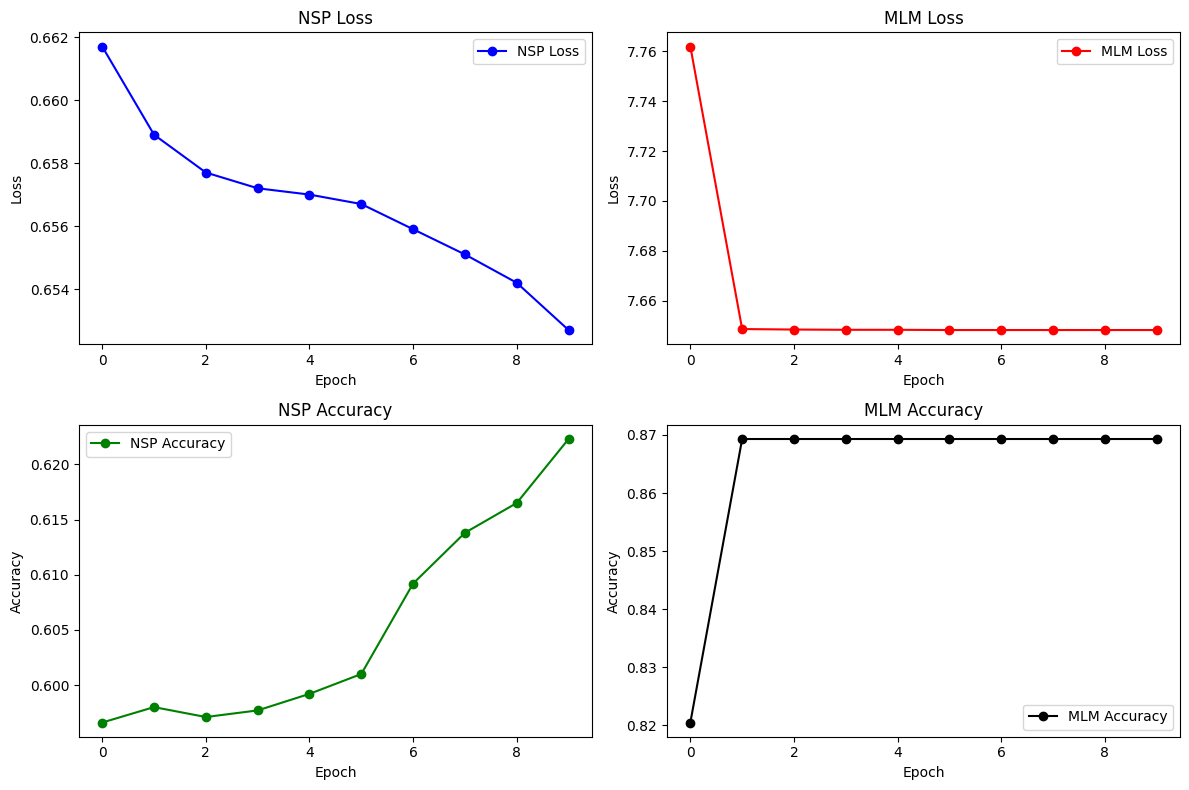

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# NSP Loss
plt.subplot(2, 2, 1)
plt.plot(history['nsp_loss'], 'b-', marker='o', label='NSP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NSP Loss')
plt.legend()

# MLM Loss
plt.subplot(2, 2, 2)
plt.plot(history['mlm_loss'], 'r-', marker='o', label='MLM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLM Loss')
plt.legend()

# NSP Accuracy
plt.subplot(2, 2, 3)
plt.plot(history['nsp_acc'], 'g-', marker='o', label='NSP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('NSP Accuracy')
plt.legend()

# MLM Accuracy
plt.subplot(2, 2, 4)
plt.plot(history['mlm_acc'], 'k-', marker='o', label='MLM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLM Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
